In [1]:
import numpy as np 
import pandas as pd
from imblearn.over_sampling import SMOTE
from keras.models import Sequential,load_model
from keras.layers import Dense, Activation, Dropout,BatchNormalization
from keras import optimizers
from keras.callbacks import Callback,History,ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# 最大顯示的行列數
pd.options.display.max_columns = None
pd.options.display.max_rows = 300
pd.options.display.max_info_rows = None

C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 整理欄位

In [2]:
hr=pd.read_csv(r'C:\Users\Guan-Ting Chen\Desktop\NCCU course2018\applied regrssion\final report\hr2.csv')
hr=hr.rename(columns={'sales':'position'})
hr=hr[['left','satisfaction_level', 'last_evaluation', 'number_project','average_montly_hours', 'time_spend_company', 'Work_accident', 
       'promotion_last_5years', 'position', 'salary']]
hr.head()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,position,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


# 轉dummy

In [3]:
hr=pd.get_dummies(hr)
hr.head()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,position_IT,position_RandD,position_accounting,position_hr,position_management,position_marketing,position_product_mng,position_sales,position_support,position_technical,salary_high,salary_low,salary_medium
0,1,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


# 0 ,1 不平衡

In [4]:
hr.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

# 先抓0,1 出來 再拆分

In [5]:
hr0=hr[hr['left']==0]
hr0=hr0.reset_index(drop=True)
hr1=hr[hr['left']==1]
hr1=hr1.reset_index(drop=True)

# 重新合成 測試 訓練集

In [6]:
x_train_0,x_test_0,y_train_0,y_test_0=train_test_split(hr0.iloc[:,1:],hr0.iloc[:,0],test_size=0.3)
x_train_1,x_test_1,y_train_1,y_test_1=train_test_split(hr1.iloc[:,1:],hr1.iloc[:,0],test_size=0.3)
x_train=pd.concat([x_train_0,x_train_1],axis=0)
x_test=pd.concat([x_test_0,x_test_1],axis=0)
x_test=scale(x_test)
y_train=pd.concat([y_train_0,y_train_1],axis=0)
y_test=pd.concat([y_test_0,y_test_1],axis=0)

C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """


# 用SMOTE生成樣本解決不平衡

In [7]:
over_samples=SMOTE(random_state=107354012)   
over_samples_X,over_samples_y=over_samples.fit_sample(x_train, y_train)  

# keras 的資料型態
- 分類的變數要用 one-encoding

In [8]:
y_train_dnn=pd.get_dummies(over_samples_y)
x_train_dnn=scale(over_samples_X)

In [9]:
y_train_dnn.head()

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


# 開始建模

In [10]:
x_train_dnn.shape

(15998, 20)

In [15]:
# define model 宣告妳要建立一個一層一層的網路(Linear stack of layers.)
dnn_model = Sequential() 

# hidden layer
dnn_model.add(Dense(50,input_dim=x_train_dnn.shape[1],activation='relu'))
dnn_model.add(Dropout(0.5))
for i in range(5):
    dnn_model.add(Dense(50))
    dnn_model.add(BatchNormalization())  #均值接近0，其標準差接近1
    dnn_model.add(Activation("relu"))
    dnn_model.add(Dropout(0.5))
# output layer
dnn_model.add(Dense(2,activation='sigmoid'))

dnn_model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
dnn_model.fit(x_train_dnn,y_train_dnn,epochs=20,batch_size=200,shuffle=True,validation_split = 0.25)

Train on 11998 samples, validate on 4000 samples
Epoch 1/20
11998/11998 [==============================] - 15s 1ms/step - loss: 0.7131 - acc: 0.5918 - val_loss: 0.8052 - val_acc: 1.2500e-04
Epoch 2/20
11998/11998 [==============================] - 1s 56us/step - loss: 0.6456 - acc: 0.6333 - val_loss: 0.7869 - val_acc: 0.0000e+00
Epoch 3/20
11998/11998 [==============================] - 1s 56us/step - loss: 0.5925 - acc: 0.6629 - val_loss: 0.7332 - val_acc: 3.7500e-04
Epoch 4/20
11998/11998 [==============================] - 1s 57us/step - loss: 0.5512 - acc: 0.6979 - val_loss: 0.6757 - val_acc: 0.9595
Epoch 5/20
11998/11998 [==============================] - 1s 57us/step - loss: 0.5143 - acc: 0.7383 - val_loss: 0.5970 - val_acc: 0.9948
Epoch 6/20
11998/11998 [==============================] - 1s 56us/step - loss: 0.4871 - acc: 0.7675 - val_loss: 0.5272 - val_acc: 0.9955
Epoch 7/20
11998/11998 [==============================] - 1s 55us/step - loss: 0.4585 - acc: 0.7848 - val_loss: 0.465

In [14]:
#dnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
__________

# 紀錄最佳模型
# 考慮容忍度

In [60]:
# checkpoint
filepath="best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# earlystopping
earlystopping = EarlyStopping(monitor="val_acc",patience=5)

callbacks_list = [checkpoint,earlystopping]

# 再run一次

In [62]:
# define model 宣告妳要建立一個一層一層的網路(Linear stack of layers.)
dnn_model = Sequential() 

# hidden layer
dnn_model.add(Dense(50,input_dim=x_train_dnn.shape[1],activation='relu'))
dnn_model.add(Dropout(0.5))
for i in range(5):
    dnn_model.add(Dense(50))
    dnn_model.add(BatchNormalization())  #均值接近0，其標準差接近1
    dnn_model.add(Activation("relu"))
    dnn_model.add(Dropout(0.5))
# output layer
dnn_model.add(Dense(2,activation='sigmoid'))

#lr=learning rate
opt= optimizers.Adamax(lr=0.002)
dnn_model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
history=dnn_model.fit(x_train_dnn,y_train_dnn,epochs=20,batch_size=200,shuffle=True,validation_split = 0.25,callbacks=callbacks_list)

Train on 11998 samples, validate on 4000 samples
Epoch 1/20
11998/11998 [==============================] - 4s 310us/step - loss: 0.7529 - acc: 0.5506 - val_loss: 0.7906 - val_acc: 0.0019

Epoch 00001: val_acc improved from 0.00050 to 0.00187, saving model to best.hdf5
Epoch 2/20
11998/11998 [==============================] - 1s 54us/step - loss: 0.6614 - acc: 0.6154 - val_loss: 0.7862 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00187
Epoch 3/20
11998/11998 [==============================] - 1s 53us/step - loss: 0.6048 - acc: 0.6548 - val_loss: 0.7346 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00187
Epoch 4/20
11998/11998 [==============================] - 1s 53us/step - loss: 0.5576 - acc: 0.6840 - val_loss: 0.6913 - val_acc: 0.8280

Epoch 00004: val_acc improved from 0.00187 to 0.82800, saving model to best.hdf5
Epoch 5/20
11998/11998 [==============================] - 1s 55us/step - loss: 0.5157 - acc: 0.7255 - val_loss: 0.6071 - val_acc

# 評估模型

In [63]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# ROC Curve

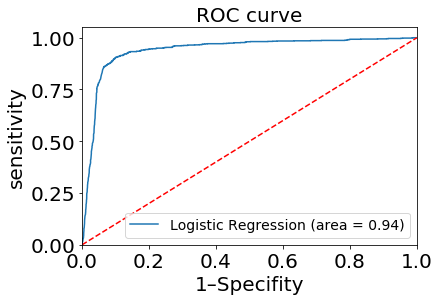

In [64]:
logit_roc_auc = roc_auc_score(y_test,dnn_model.predict(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test,dnn_model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1–Specifity',fontsize=20)
plt.ylabel('sensitivity',fontsize=20)
plt.title('ROC curve',fontsize=20)
plt.legend(loc="lower right",fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 20)
ax.tick_params(axis = 'y', which = 'major', labelsize = 20)
plt.show()

# 渾淆矩陣

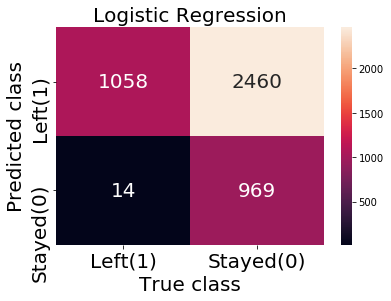

In [65]:
logreg_y_pred = dnn_model.predict_classes(x_test)
logreg_cm =confusion_matrix(logreg_y_pred,y_test,[1,0])
sns.heatmap(logreg_cm,annot=True, fmt='.0f',xticklabels = ["Left(1)", "Stayed(0)"] , yticklabels = ["Left(1)", "Stayed(0)"],annot_kws={"size": 20})
plt.ylabel('Predicted class',fontsize=20)
plt.xlabel('True class',fontsize=20)
plt.title('Logistic Regression',fontsize=20)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 20)
ax.tick_params(axis = 'y', which = 'major', labelsize = 20)

Text(0.5,1,'Validation accuracy')

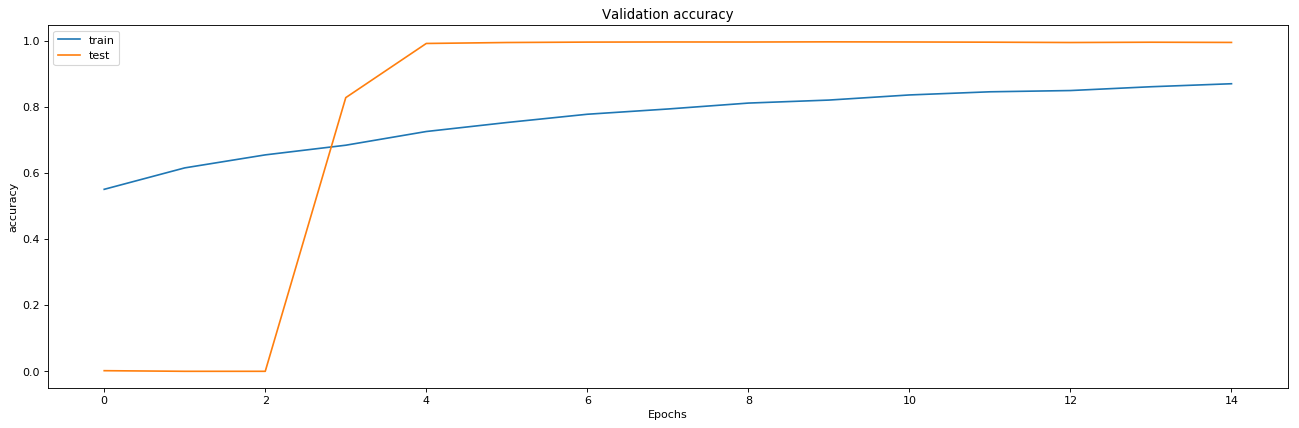

In [66]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.title("Validation accuracy")